In [2]:
import numpy as np
from layers import nms, iou, acc
import pandas as pd
import time
import multiprocessing as mp
import matplotlib.pyplot as plt
import glob
import os
import pydicom as dicom
from config_submit import config as config_submit
from scipy.special import expit

In [3]:
# get list of scans
patientlist = glob.glob(config_submit['preprocess_result_path']+'*clean.npy')
patient_short = []
for patient in patientlist:
    patient_short.append(patient.split('_')[-2].split('/')[-1])
print patient_short

['8b9a2378b94d14526f266148c7991e78f20fd1f4', '06ea1ff317a8652bb74f6710efa3b758be96524e', '8a5a850d1f90a3b5e4cb6a3a137ac6be0c6768d9', 'ce1ff1a4-180d882f-5401a107-db5428b4-f58b0322', '6e0d4bef9a6a3c88d1c24cbb4e64d26526ad7cb1', 'ded4983b-85e8b6b0-9b9c0898-232b7d47-c2122a5d', 'c5aeb59f-9b52b436-4c12187a-fd90406d-fb55cc4b', '000014.mhd']


In [4]:
from preprocessing.step1 import load_scan, get_pixels_hu

/Library/Python/2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
patient = patient_short[2]
print(patient)

8a5a850d1f90a3b5e4cb6a3a137ac6be0c6768d9


In [5]:
dicom_dir = config_submit['datapath']+patient
case = load_scan(dicom_dir)
print case[0]
case_pixels, spacing = get_pixels_hu(case)
print case_pixels.shape
boundbox = np.load(config_submit['preprocess_result_path']+patient+'_box.npy')
print boundbox
image_clean = np.load(config_submit['preprocess_result_path']+patient+'_clean.npy')

(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'HELIX']
(0008, 0012) Instance Creation Date              DA: '20171018'
(0008, 0013) Instance Creation Time              TM: '154949'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.2831219200.13583.1508913943.403461
(0008, 0020) Study Date                          DA: '20171018'
(0008, 0022) Acquisition Date                    DA: '20171018'
(0008, 0023) Content Date                        DA: '20171018'
(0008, 0030) Study Time                          TM: '154458'
(0008, 0032) Acquisition Time                    TM: '154629'
(0008, 0033) Content Time                        TM: '154644.257999'
(0008, 0050) Accession Number                    SH: 'ZXxxxxxxx'
(0008, 0060) Modality                            CS: 'CT'
(0008, 0070) Manufacturer                        LO: 'Philips'
(0008, 0080) Institution N

(414, 512, 512)
[[ 34 310]
 [ 96 258]
 [ 51 303]]


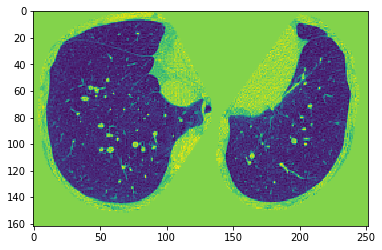

In [6]:
plt.imshow(image_clean[0][70])
plt.show()

NameError: name 'pbb2' is not defined

In [14]:
pbb2

array([[  9.99784529e-01,   1.60857758e+02,   8.09662781e+01,
          2.50723591e+01,   7.89151764e+00],
       [  9.98960972e-01,   1.33714844e+02,   1.44817719e+02,
          5.77009468e+01,   8.52952480e+00],
       [  9.98460293e-01,   1.24897659e+02,   1.46316971e+02,
          4.94529572e+01,   8.25657749e+00],
       [  9.86556828e-01,   9.80749435e+01,   1.37049042e+02,
          1.57689728e+02,   8.58448887e+00],
       [  9.48048830e-01,   1.09360954e+02,   1.45589157e+02,
          1.93666443e+02,   9.44842720e+00],
       [  8.69630754e-01,   1.01395645e+02,   3.42976418e+01,
          6.14384499e+01,   3.08238316e+01],
       [  7.30287254e-01,   1.81381454e+02,   6.99474258e+01,
          1.53596802e+02,   1.12289000e+01],
       [  6.63426876e-01,   4.16080360e+01,   1.05306053e+02,
          2.25532822e+02,   8.59235764e+00],
       [  5.60461164e-01,   8.50389481e+01,   1.17937004e+02,
          2.05742264e+02,   8.28865814e+00],
       [  2.76918083e-01,   7.7413765

In [15]:
for save_id in range(1):#range(len(patient_short)):
    df = []
    print(save_id)
    patient = patient_short[save_id]
    print patient
    pbbdir = './bbox_result/'+patient+'_pbb.npy'
    lbbdir = './bbox_result/'+patient+'_lbb.npy'
    pbb = np.load(pbbdir)
    lbb = np.load(lbbdir)
## the patient list here ## where you can change the directory id
    dicom_dir = config_submit['datapath']+patient
    case = load_scan(dicom_dir)
    case_pixels, spacing = get_pixels_hu(case)
    
    boundbox = np.load(config_submit['preprocess_result_path']+patient+'_box.npy')
    image_clean = np.load(config_submit['preprocess_result_path']+patient+'_clean.npy')
    pbb2 = nms(pbb,nms_th = 0.05)
    #print pbb2
    pbb2[:, 0] = expit(pbb2[:, 0])
    print pbb2
    image_clean = image_clean[0]  #4D to 3D
    # pbb 2 probability
    cands = pbb2 # z y x
    cands_spacing = cands
    #cands_spacing[:,1:4] = pbb2[:,1:4]
    cands_spacing[:,1:4] = (boundbox[:,0]+pbb2[:,1:4])/spacing
    cands_spacing = np.append(cands_spacing,np.random.choice(a=[False, True], size=(len(cands_spacing[:,0]), 1), p=[0.5, 0.5]),axis =1)
    cands_spacing = np.append(cands_spacing,np.random.randn(len(cands_spacing[:,0]), 1)*255,axis =1)
    cands_spacing = np.append(cands_spacing,np.random.choice(a=[False, True], size=(len(cands_spacing[:,0]), 1), p=[0.5, 0.5]),axis =1)
    print(pd.DataFrame(cands_spacing))
    df =pd.DataFrame(cands_spacing)
    #df_index = pd.DataFrame(columns=['probability', 'index_z', 'index_y','index_x','diameter','is upper lober','HU_mean','Clinical decision'])
    df.columns=['probability', 'index_z', 'index_y','index_x','diameter','is upper lober','HU_mean','Clinical decision']
    df.to_csv('./predictions/'+patient_short[save_id]+'.csv', index=False)

0
8a5a850d1f90a3b5e4cb6a3a137ac6be0c6768d9
[[  9.99784529e-01   1.60857758e+02   8.09662781e+01   2.50723591e+01
    7.89151764e+00]
 [  9.98960972e-01   1.33714844e+02   1.44817719e+02   5.77009468e+01
    8.52952480e+00]
 [  9.98460293e-01   1.24897659e+02   1.46316971e+02   4.94529572e+01
    8.25657749e+00]
 [  9.86556828e-01   9.80749435e+01   1.37049042e+02   1.57689728e+02
    8.58448887e+00]
 [  9.48048830e-01   1.09360954e+02   1.45589157e+02   1.93666443e+02
    9.44842720e+00]
 [  8.69630754e-01   1.01395645e+02   3.42976418e+01   6.14384499e+01
    3.08238316e+01]
 [  7.30287254e-01   1.81381454e+02   6.99474258e+01   1.53596802e+02
    1.12289000e+01]
 [  6.63426876e-01   4.16080360e+01   1.05306053e+02   2.25532822e+02
    8.59235764e+00]
 [  5.60461164e-01   8.50389481e+01   1.17937004e+02   2.05742264e+02
    8.28865814e+00]
 [  2.76918083e-01   7.74137650e+01   1.24968575e+02   2.17687912e+02
    8.60774994e+00]
 [  1.65626794e-01   1.77416260e+02   1.12892784e+02   8.

[[  9.99784529e-01   9.69288788e+01   2.81462158e+02   1.00543564e+02
    7.89151764e+00   1.00000000e+00  -2.97307800e+02   1.00000000e+00]
 [  9.98960972e-01   8.33574219e+01   3.86580933e+02   1.54260086e+02
    8.52952480e+00   1.00000000e+00  -4.77511659e+02   0.00000000e+00]
 [  9.98460293e-01   7.89488297e+01   3.89049164e+02   1.40681396e+02
    8.25657749e+00   0.00000000e+00   1.45071120e+01   1.00000000e+00]
 [  9.86556828e-01   6.55374756e+01   3.73791351e+02   3.18871826e+02
    8.58448887e+00   1.00000000e+00  -3.05333598e+02   1.00000000e+00]
 [  9.48048830e-01   7.11804810e+01   3.87850952e+02   3.78100372e+02
    9.44842720e+00   0.00000000e+00   2.65506093e+02   0.00000000e+00]
 [  8.69630754e-01   6.71978226e+01   2.04631485e+02   1.60413132e+02
    3.08238316e+01   1.00000000e+00   2.47485336e+02   1.00000000e+00]
 [  7.30287254e-01   1.07190727e+02   2.63321808e+02   3.12133636e+02
    1.12289000e+01   1.00000000e+00   1.39683747e+02   1.00000000e+00]
 [  6.6342687

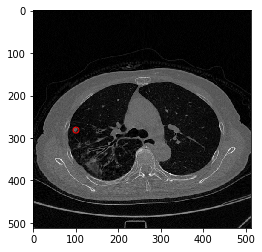

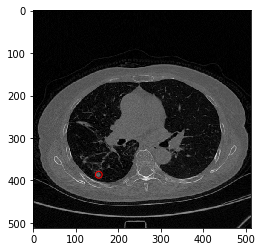

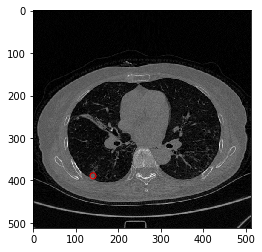

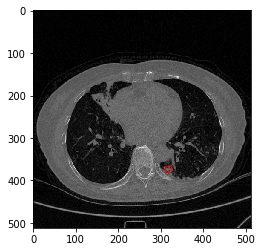

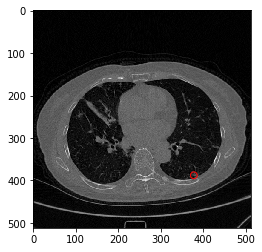

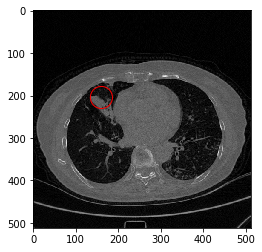

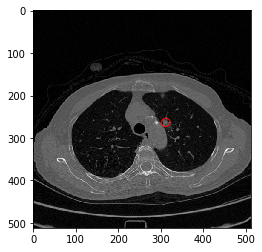

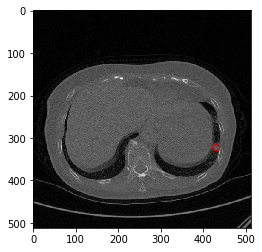

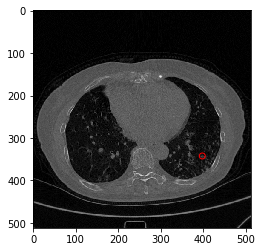

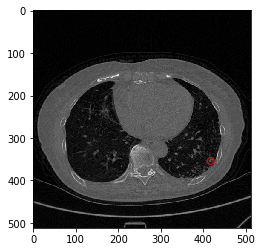

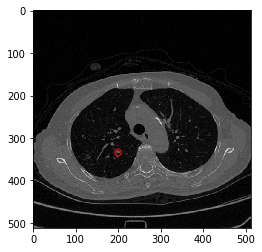

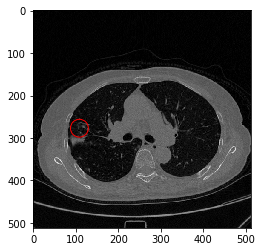

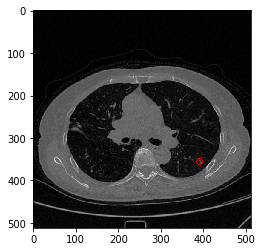

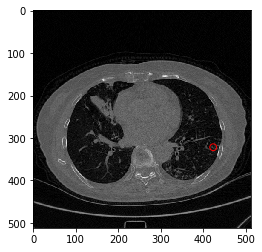

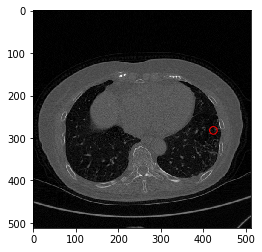

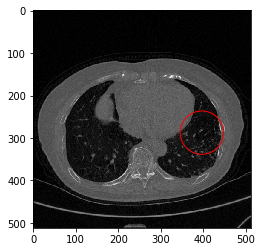

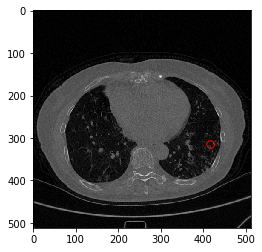

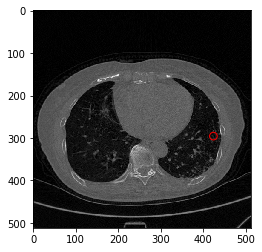

In [16]:
print cands_spacing
for voxelCoord in cands_spacing:
    #worldCoord = np.asarray([float(cand[3]),float(cand[2]),float(cand[1])])
    #voxelCoord = worldToVoxelCoord(worldCoord, numpyOrigin, numpySpacing)
    #patch = numpyImage[int(voxelCoord[1]),iresultsnt(voxelCoord[2]-voxelWidth/2):int(voxelCoord[2]+voxelWidth/2),
    #                   int(voxelCoord[1]-voxelWidth/2):int(voxelCoord[1]+voxelWidth/2)]
    #patch = normalizePlanes(patch)
    #plt.imshow(patch, cmap='gray')
    plt.imshow(case_pixels[int(voxelCoord[1])],cmap = 'gray')
    ax = plt.gca()
    #plot using patch centre;
    radi = float(voxelCoord[4])/2/spacing[2]+1
    circle = plt.Circle((voxelCoord[3],voxelCoord[2]),int(radi),fill = False, color = 'r')
    #circle=plt.Circle((voxelWidth/2+1,voxelWidth/2+1),int(radi),fill = False,color = 'r')
    ax.add_artist(circle)
    plt.show()   

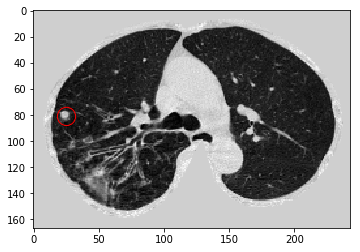

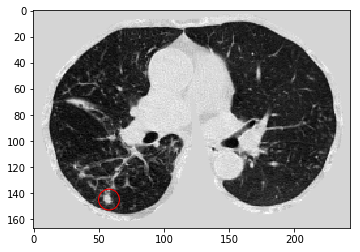

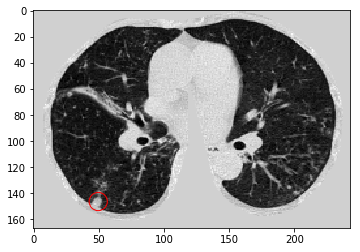

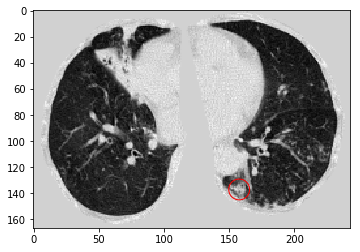

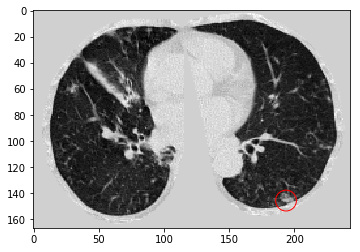

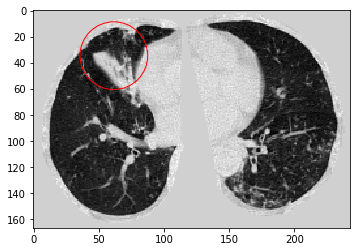

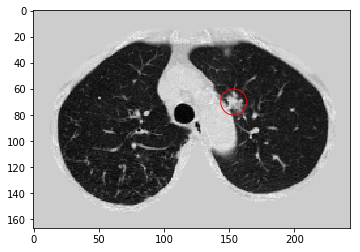

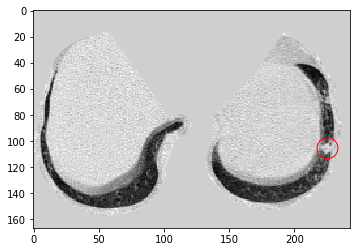

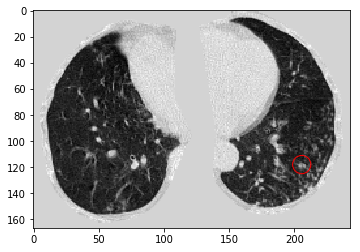

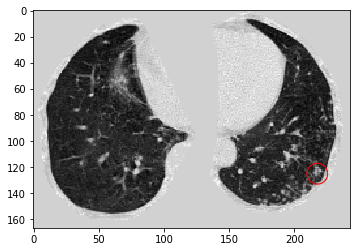

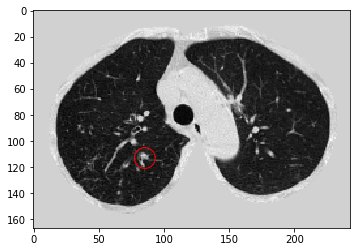

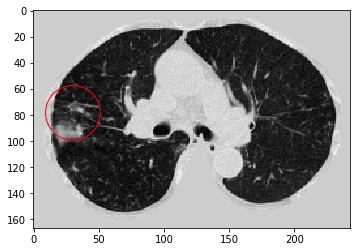

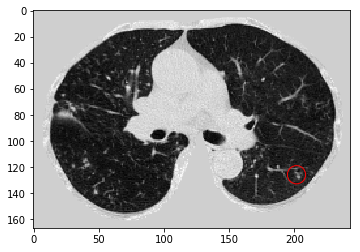

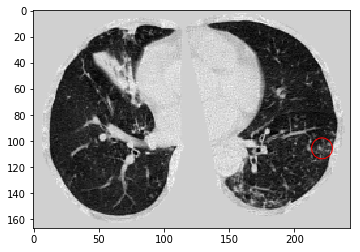

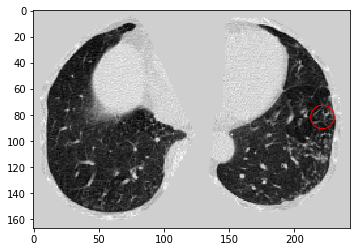

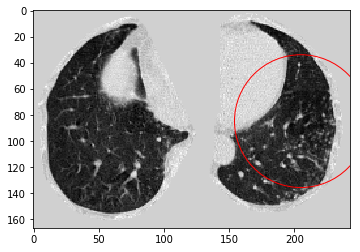

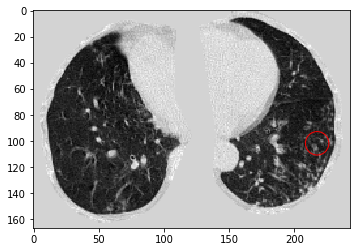

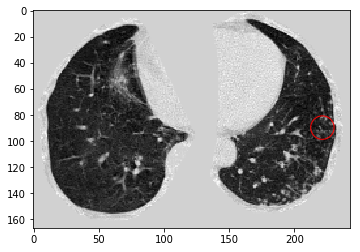

In [11]:
# here using image_clean 
for voxelCoord in cands:
    #worldCoord = np.asarray([float(cand[3]),float(cand[2]),float(cand[1])])
    #voxelCoord = worldToVoxelCoord(worldCoord, numpyOrigin, numpySpacing)
    #patch = numpyImage[int(voxelCoord[1]),iresultsnt(voxelCoord[2]-voxelWidth/2):int(voxelCoord[2]+voxelWidth/2),
    #                   int(voxelCoord[1]-voxelWidth/2):int(voxelCoord[1]+voxelWidth/2)]
    #patch = normalizePlanes(patch)
    #plt.imshow(patch, cmap='gray')
    plt.imshow(image_clean[int(voxelCoord[1])],cmap = 'gray')
    ax = plt.gca()
    #plot using patch centre;
    radi = float(voxelCoord[4])/2/spacing[2]+1
    circle = plt.Circle((voxelCoord[3],voxelCoord[2]),int(radi),fill = False, color = 'r')
    #circle=plt.Circle((voxelWidth/2+1,voxelWidth/2+1),int(radi),fill = False,color = 'r')
    ax.add_artist(circle)
    plt.show()   
    #return [{"x": int(p[3]), "y": intny workers as (p[2]), "z": int(p[1]), "p_nodule": float(p[0])} for p in proposals]

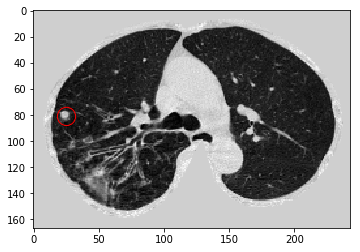

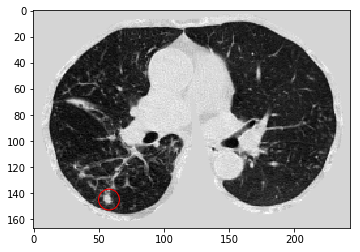

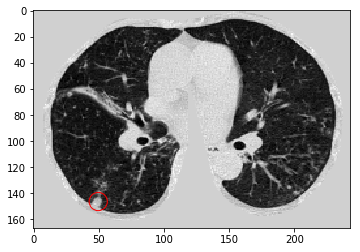

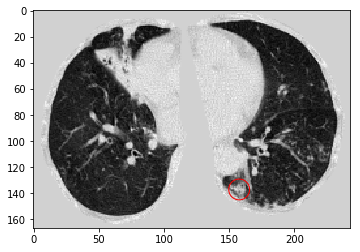

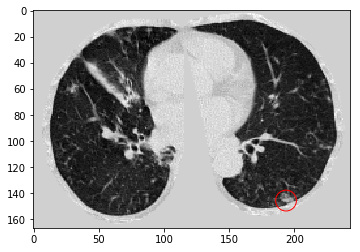

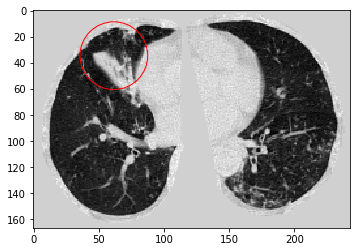

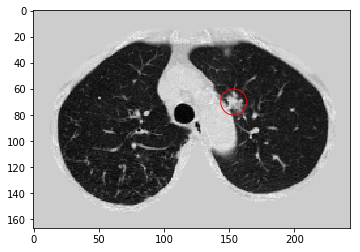

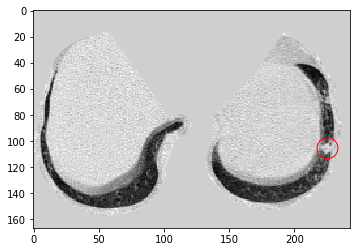

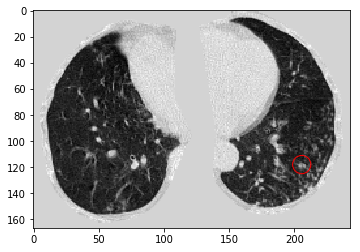

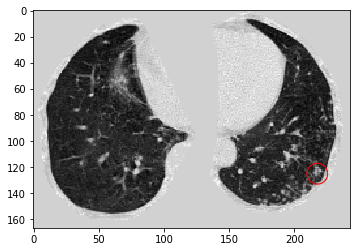

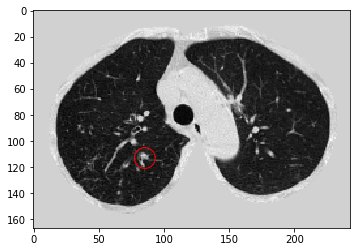

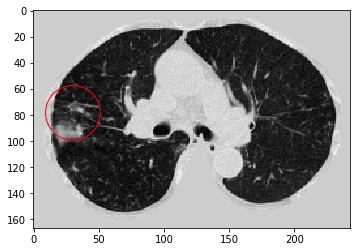

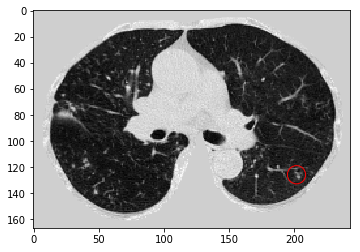

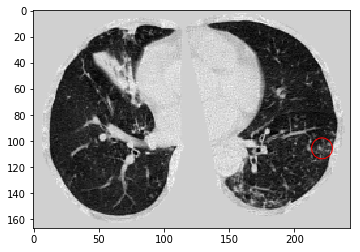

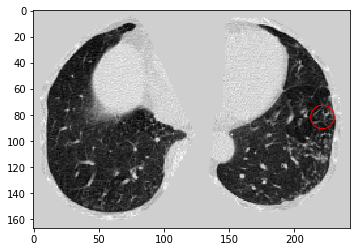

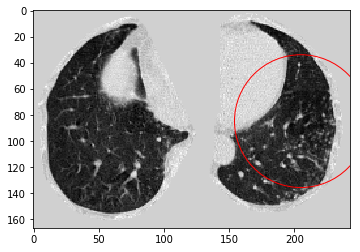

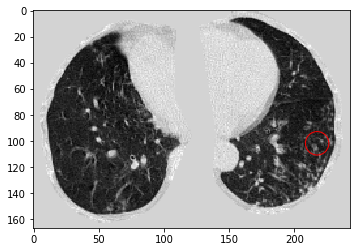

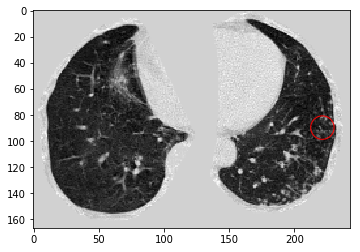

In [12]:
# here using image_clean 
for voxelCoord in cands:
    #worldCoord = np.asarray([float(cand[3]),float(cand[2]),float(cand[1])])
    #voxelCoord = worldToVoxelCoord(worldCoord, numpyOrigin, numpySpacing)
    #patch = numpyImage[int(voxelCoord[1]),iresultsnt(voxelCoord[2]-voxelWidth/2):int(voxelCoord[2]+voxelWidth/2),
    #                   int(voxelCoord[1]-voxelWidth/2):int(voxelCoord[1]+voxelWidth/2)]
    #patch = normalizePlanes(patch)
    #plt.imshow(patch, cmap='gray')
    plt.imshow(image_clean[int(voxelCoord[1])],cmap = 'gray')
    ax = plt.gca()
    #plot using patch centre;
    radi = float(voxelCoord[4])/2/spacing[2]+1
    circle = plt.Circle((voxelCoord[3],voxelCoord[2]),int(radi),fill = False, color = 'r')
    #circle=plt.Circle((voxelWidth/2+1,voxelWidth/2+1),int(radi),fill = False,color = 'r')
    ax.add_artist(circle)
    plt.show()   
    #return [{"x": int(p[3]), "y": intny workers as (p[2]), "z": int(p[1]), "p_nodule": float(p[0])} for p in proposals] 